# GoDaddy - Microbusiness Density Forecasting

Goal of the Competition

The goal of this competition is to predict monthly microbusiness density in a given area. You will develop an accurate model trained on U.S. county-level data.

Your work will help policymakers gain visibility into microbusinesses, a growing trend of very small entities. Additional information will enable new policies and programs to improve the success and impact of these smallest of businesses.


## My approach

Train 1 model for all areas and use it for recursive forecasting: predicting next day based on predictions of the previous days. During experiments Random Forest have shown the best results. 


In [1]:
import gc
import numpy as np
import pandas as pd
import xgboost as xgb
from tqdm.notebook import tqdm
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor


IS_LOCAL = True

if IS_LOCAL:
    BASE = 'data/'
else:
    BASE = '../input/godaddy-microbusiness-density-forecasting/'

In [2]:
train = pd.read_csv(BASE + 'train.csv')
test = pd.read_csv(BASE + 'test.csv')
test_upd = pd.read_csv(BASE + 'revealed_test.csv')
sub = pd.read_csv(BASE + 'sample_submission.csv')
train.shape, test.shape, test_upd.shape, sub.shape

((122265, 7), (25080, 3), (6270, 7), (25080, 2))

In [3]:
train.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [4]:
test.head()

,row_id,cfips,first_day_of_month
0,1001_2022-11-01,1001,2022-11-01
1,1003_2022-11-01,1003,2022-11-01
2,1005_2022-11-01,1005,2022-11-01
3,1007_2022-11-01,1007,2022-11-01
4,1009_2022-11-01,1009,2022-11-01


In [5]:
test_upd.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2022-11-01,1001,Autauga County,Alabama,2022-11-01,3.442677,1463
1,1001_2022-12-01,1001,Autauga County,Alabama,2022-12-01,3.470915,1475
2,1003_2022-11-01,1003,Baldwin County,Alabama,2022-11-01,8.257636,14145
3,1003_2022-12-01,1003,Baldwin County,Alabama,2022-12-01,8.250630,14133
4,1005_2022-11-01,1005,Barbour County,Alabama,2022-11-01,1.247223,247


In [6]:
test_upd_months = test_upd['first_day_of_month'].value_counts().index.to_list()
print('Months in updated test data: '+ str(test_upd_months))

Months in updated test data: ['2022-11-01', '2022-12-01']


Update train with updated test data

In [7]:
train = pd.concat((train, test_upd)).sort_values('row_id').reset_index(drop=True)

In [8]:
train['first_day_of_month'].value_counts().sort_index()

first_day_of_month
2019-08-01    3135
2019-09-01    3135
2019-10-01    3135
2019-11-01    3135
2019-12-01    3135
2020-01-01    3135
2020-02-01    3135
2020-03-01    3135
2020-04-01    3135
2020-05-01    3135
2020-06-01    3135
2020-07-01    3135
2020-08-01    3135
2020-09-01    3135
2020-10-01    3135
2020-11-01    3135
2020-12-01    3135
2021-01-01    3135
2021-02-01    3135
2021-03-01    3135
2021-04-01    3135
2021-05-01    3135
2021-06-01    3135
2021-07-01    3135
2021-08-01    3135
2021-09-01    3135
2021-10-01    3135
2021-11-01    3135
2021-12-01    3135
2022-01-01    3135
2022-02-01    3135
2022-03-01    3135
2022-04-01    3135
2022-05-01    3135
2022-06-01    3135
2022-07-01    3135
2022-08-01    3135
2022-09-01    3135
2022-10-01    3135
2022-11-01    3135
2022-12-01    3135
Name: count, dtype: int64

In [9]:
test = test.loc[~test['first_day_of_month'].isin(test_upd_months)]
test['first_day_of_month'].value_counts()

first_day_of_month
2023-01-01    3135
2023-02-01    3135
2023-03-01    3135
2023-04-01    3135
2023-05-01    3135
2023-06-01    3135
Name: count, dtype: int64

In [10]:
train.loc[:, 'istest'] = 0
test.loc[:, 'istest'] = 1
raw = pd.concat((train, test)).sort_values('first_day_of_month').reset_index(drop=True)
raw.tail(10)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest
147335,21103_2023-06-01,21103,NaN,NaN,2023-06-01,NaN,NaN,1
147336,21105_2023-06-01,21105,NaN,NaN,2023-06-01,NaN,NaN,1
147337,21107_2023-06-01,21107,NaN,NaN,2023-06-01,NaN,NaN,1
147338,21109_2023-06-01,21109,NaN,NaN,2023-06-01,NaN,NaN,1
147339,21111_2023-06-01,21111,NaN,NaN,2023-06-01,NaN,NaN,1
147340,21113_2023-06-01,21113,NaN,NaN,2023-06-01,NaN,NaN,1
147341,21115_2023-06-01,21115,NaN,NaN,2023-06-01,NaN,NaN,1
147342,21117_2023-06-01,21117,NaN,NaN,2023-06-01,NaN,NaN,1
147343,21121_2023-06-01,21121,NaN,NaN,2023-06-01,NaN,NaN,1
147344,56045_2023-06-01,56045,NaN,NaN,2023-06-01,NaN,NaN,1


In [11]:
raw['first_day_of_month'] = pd.to_datetime(raw["first_day_of_month"])
raw['county'] = raw.groupby('cfips')['county'].ffill()
raw['state'] = raw.groupby('cfips')['state'].ffill()
raw["year"] = raw["first_day_of_month"].dt.year
raw["month"] = raw["first_day_of_month"].dt.month
raw["dcount"] = raw.groupby(['cfips'])['row_id'].cumcount()
raw['county_i'] = (raw['county'] + raw['state']).factorize()[0]
raw['state_i'] = raw['state'].factorize()[0]
raw.tail(10)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_i,state_i
147335,21103_2023-06-01,21103,Henry County,Kentucky,2023-06-01,NaN,NaN,1,2023,6,46,772,13
147336,21105_2023-06-01,21105,Hickman County,Kentucky,2023-06-01,NaN,NaN,1,2023,6,46,784,13
147337,21107_2023-06-01,21107,Hopkins County,Kentucky,2023-06-01,NaN,NaN,1,2023,6,46,802,13
147338,21109_2023-06-01,21109,Jackson County,Kentucky,2023-06-01,NaN,NaN,1,2023,6,46,829,13
147339,21111_2023-06-01,21111,Jefferson County,Kentucky,2023-06-01,NaN,NaN,1,2023,6,46,822,13
147340,21113_2023-06-01,21113,Jessamine County,Kentucky,2023-06-01,NaN,NaN,1,2023,6,46,820,13
147341,21115_2023-06-01,21115,Johnson County,Kentucky,2023-06-01,NaN,NaN,1,2023,6,46,818,13
147342,21117_2023-06-01,21117,Kenton County,Kentucky,2023-06-01,NaN,NaN,1,2023,6,46,817,13
147343,21121_2023-06-01,21121,Knox County,Kentucky,2023-06-01,NaN,NaN,1,2023,6,46,810,13
147344,56045_2023-06-01,56045,Weston County,Wyoming,2023-06-01,NaN,NaN,1,2023,6,46,686,27


### Removing outliers

In [12]:
outliers = []
cnt = 0
for o in tqdm(raw.cfips.unique()):
    indices = (raw['cfips']==o)
    tmp = raw.loc[indices].copy().reset_index(drop=True)
    var = tmp.microbusiness_density.values.copy()
    #vmax = np.max(var[:38]) - np.min(var[:38])

    for i in range(40, 0, -1):
        thr = 0.20*np.mean(var[:i])
        difa = abs(var[i]-var[i-1])
        if (difa>=thr):
            var[:i] *= (var[i]/var[i-1])
            outliers.append(o)
            cnt+=1
    var[0] = var[1]*0.99
    raw.loc[indices, 'microbusiness_density'] = var

outliers = np.unique(outliers)
len(outliers), cnt

  0%|          | 0/3135 [00:00<?, ?it/s]

/var/folders/g4/vcr7dfjn0xgbnjjdj8yj4gtr0000gn/T/ipykernel_65385/3954104063.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  var[:i] *= (var[i]/var[i-1])
/var/folders/g4/vcr7dfjn0xgbnjjdj8yj4gtr0000gn/T/ipykernel_65385/3954104063.py:13: RuntimeWarning: invalid value encountered in multiply
  var[:i] *= (var[i]/var[i-1])
/var/folders/g4/vcr7dfjn0xgbnjjdj8yj4gtr0000gn/T/ipykernel_65385/3954104063.py:11: RuntimeWarning: invalid value encountered in double_scalars
  difa = abs(var[i]-var[i-1])


(552, 903)

In [13]:
raw = raw.replace([np.inf, -np.inf], np.nan)
raw['microbusiness_density'] = raw.groupby('cfips')['microbusiness_density'].bfill()

In [14]:
raw.loc[raw['microbusiness_density'].isna()]

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_i,state_i
128535,39093_2023-01-01,39093,Lorain County,Ohio,2023-01-01,NaN,NaN,1,2023,1,41,761,20
128536,39095_2023-01-01,39095,Lucas County,Ohio,2023-01-01,NaN,NaN,1,2023,1,41,763,20
128537,39105_2023-01-01,39105,Meigs County,Ohio,2023-01-01,NaN,NaN,1,2023,1,41,710,20
128538,39097_2023-01-01,39097,Madison County,Ohio,2023-01-01,NaN,NaN,1,2023,1,41,765,20
128539,39099_2023-01-01,39099,Mahoning County,Ohio,2023-01-01,NaN,NaN,1,2023,1,41,737,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
147340,21113_2023-06-01,21113,Jessamine County,Kentucky,2023-06-01,NaN,NaN,1,2023,6,46,820,13
147341,21115_2023-06-01,21115,Johnson County,Kentucky,2023-06-01,NaN,NaN,1,2023,6,46,818,13
147342,21117_2023-06-01,21117,Kenton County,Kentucky,2023-06-01,NaN,NaN,1,2023,6,46,817,13
147343,21121_2023-06-01,21121,Knox County,Kentucky,2023-06-01,NaN,NaN,1,2023,6,46,810,13


SMAPE

In [15]:
def smape(y_true, y_pred):
    smap = np.zeros(len(y_true))

    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)

    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]

    return 100 * np.mean(smap)


## Validation

Getting last 4 months from train for validation period

In [16]:
valid_period = raw.loc[raw['istest'] == 0, 'dcount'].sort_values().unique().tolist()[-4:]
valid_period

[37, 38, 39, 40]

Splitting the data for validation

In [17]:
# Making copy of raw dateset, beacuse we will remove target
train = raw.loc[raw['istest'] == 0].copy()

# Removing target to simulate test set and keeping y_true values
train.loc[train['dcount'].isin(valid_period), 'y_true_val'] = train.loc[train['dcount'].isin(valid_period), 'microbusiness_density']
train.loc[train['dcount'].isin(valid_period), 'microbusiness_density'] = np.nan

### Feature engineering

In [19]:
def build_features(df):
    df = df.sort_values('first_day_of_month', ascending=True)
    features = []
    for lag in range(1, 18):
        df[f'mbd_lag_{lag}'] = df.groupby('cfips')['microbusiness_density'].shift(lag)
        df[f'mbd_lag_{lag}'] = df.groupby('cfips')[f'mbd_lag_{lag}'].bfill()
        features.append(f'mbd_lag_{lag}')

    for win in [3, 6, 12, 18]:
        df[f'mbd_rmean_{win}'] = df.sort_values(['cfips', 'first_day_of_month'], ascending=True)\
            .groupby('cfips')['microbusiness_density'].transform(lambda x: x.rolling(win).mean().shift().bfill())
        features.append(f'mbd_rmean_{win}')

    return df, features

train, features = build_features(train)
gc.collect()

0

In [20]:
train.tail(6)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,...,mbd_lag_12,mbd_lag_13,mbd_lag_14,mbd_lag_15,mbd_lag_16,mbd_lag_17,mbd_rmean_3,mbd_rmean_6,mbd_rmean_12,mbd_rmean_18
126446,39031_2022-12-01,39031,Coshocton County,Ohio,2022-12-01,NaN,494.0,0,2022,12,...,1.705887,1.716615,1.709463,1.709463,1.727344,1.716615,NaN,NaN,NaN,NaN
126447,39033_2022-12-01,39033,Crawford County,Ohio,2022-12-01,NaN,656.0,0,2022,12,...,1.940084,1.906423,1.918663,1.909483,2.022706,1.995165,NaN,NaN,NaN,NaN
126448,39035_2022-12-01,39035,Cuyahoga County,Ohio,2022-12-01,NaN,69914.0,0,2022,12,...,6.865680,6.828369,6.653979,6.623461,6.612309,6.585136,NaN,NaN,NaN,NaN
126449,39037_2022-12-01,39037,Darke County,Ohio,2022-12-01,NaN,734.0,0,2022,12,...,1.874570,1.874570,1.874570,1.861817,1.851616,1.826111,NaN,NaN,NaN,NaN
126451,39039_2022-12-01,39039,Defiance County,Ohio,2022-12-01,NaN,726.0,0,2022,12,...,2.387114,2.353061,2.325819,2.312198,2.284956,2.281550,NaN,NaN,NaN,NaN
128534,28109_2022-12-01,28109,Pearl River County,Mississippi,2022-12-01,NaN,1072.0,0,2022,12,...,2.305805,2.315150,2.331503,2.301133,2.385235,2.389908,NaN,NaN,NaN,NaN


Fitting the models on train data

In [21]:
%%time

SEED = 42

X_train = train.loc[~train['dcount'].isin(valid_period), features]
y_train = train.loc[~train['dcount'].isin(valid_period), 'microbusiness_density']

rf_model = RandomForestRegressor(random_state=SEED, n_jobs=-1)

rf_model.fit(X_train, y_train)

CPU times: user 5min 32s, sys: 2.25 s, total: 5min 35s
Wall time: 39.1 s


RandomForestRegressor(n_jobs=-1, random_state=42)

In [22]:
# cb_model = CatBoostRegressor(random_state=SEED)
#
# cb_model.fit(X_train, y_train, verbose=True)

In [23]:
# Create column where we will store our predictions
train['valid_preds'] = np.nan

for step in range(len(valid_period)):
    print('step == {}'.format(step))

    # Getting current valid dcount for prediction
    valid_dcount = valid_period[step]

    valid_indices = train['dcount'] == valid_dcount

    # display(train.loc[valid_indices,  ['microbusiness_density'] + features].tail(8))

    X_valid = train.loc[valid_indices,  features]
    y_valid = train.loc[valid_indices,  'y_true_val']

    preds = rf_model.predict(X_valid) #* 1.001
    # preds = cb_model.predict(X_valid)
    train.loc[valid_indices, 'valid_preds'] = preds

    step_smape = smape(y_valid, preds)
    print(f'SMAPE for step {step} == {step_smape}')

    # Updating target with predictions and regeneration of features
    train.loc[valid_indices, 'microbusiness_density'] = preds
    train, features = build_features(train)


step == 0
SMAPE for step 0 == 1.2176842662887024
step == 1
SMAPE for step 1 == 1.8113778310623336
step == 2
SMAPE for step 2 == 2.2912488920992016
step == 3
SMAPE for step 3 == 2.9571681171018374


In [24]:
valid_y_true = train.loc[train['dcount'].isin(valid_period), 'y_true_val']
valid_y_preds = train.loc[train['dcount'].isin(valid_period), 'valid_preds']
smape(valid_y_true, valid_y_preds)

2.0693697766380184

 ## Submit

In [25]:
test_period = raw.loc[raw['istest'] == 1, 'dcount'].sort_values().unique().tolist()
test_period

[41, 42, 43, 44, 45, 46]

In [26]:
raw, features = build_features(raw)

In [27]:
raw.tail(20)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,...,mbd_lag_12,mbd_lag_13,mbd_lag_14,mbd_lag_15,mbd_lag_16,mbd_lag_17,mbd_rmean_3,mbd_rmean_6,mbd_rmean_12,mbd_rmean_18
145242,56011_2023-06-01,56011,Crook County,Wyoming,2023-06-01,NaN,NaN,1,2023,6,...,3.882810,3.900459,3.971055,3.971055,3.971055,3.935757,NaN,NaN,NaN,NaN
145243,56013_2023-06-01,56013,Fremont County,Wyoming,2023-06-01,NaN,NaN,1,2023,6,...,3.152441,3.132255,3.132255,3.128890,3.115432,3.101975,NaN,NaN,NaN,NaN
145244,56015_2023-06-01,56015,Goshen County,Wyoming,2023-06-01,NaN,NaN,1,2023,6,...,1.869512,1.878954,1.916722,1.793976,1.746766,1.756208,NaN,NaN,NaN,NaN
145245,56017_2023-06-01,56017,Hot Springs County,Wyoming,2023-06-01,NaN,NaN,1,2023,6,...,3.737043,3.709765,3.764321,3.818876,3.682488,3.709765,NaN,NaN,NaN,NaN
145246,56019_2023-06-01,56019,Johnson County,Wyoming,2023-06-01,NaN,NaN,1,2023,6,...,18.738106,18.913774,19.001610,18.943054,19.045528,18.943054,NaN,NaN,NaN,NaN
145247,56001_2023-06-01,56001,Albany County,Wyoming,2023-06-01,NaN,NaN,1,2023,6,...,4.555388,4.536920,4.740066,4.755456,4.780079,4.817015,NaN,NaN,NaN,NaN
145248,56021_2023-06-01,56021,Laramie County,Wyoming,2023-06-01,NaN,NaN,1,2023,6,...,13.257378,13.443125,13.555619,13.726977,13.645877,13.696892,NaN,NaN,NaN,NaN
145249,56025_2023-06-01,56025,Natrona County,Wyoming,2023-06-01,NaN,NaN,1,2023,6,...,5.773817,5.711326,5.763949,5.721192,5.666925,5.643901,NaN,NaN,NaN,NaN
145250,56027_2023-06-01,56027,Niobrara County,Wyoming,2023-06-01,NaN,NaN,1,2023,6,...,1.713062,1.766595,1.766595,1.820128,1.820128,1.873662,NaN,NaN,NaN,NaN
145251,56029_2023-06-01,56029,Park County,Wyoming,2023-06-01,NaN,NaN,1,2023,6,...,6.101229,6.058262,6.023890,5.989516,5.882100,5.890694,NaN,NaN,NaN,NaN


In [28]:
%time

SEED = 42

X_train = raw.loc[~raw['dcount'].isin(test_period), features]
y_train = raw.loc[~raw['dcount'].isin(test_period), 'microbusiness_density']

rf_model = RandomForestRegressor(random_state=SEED, n_jobs=-1)

rf_model.fit(X_train, y_train)


CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 2.15 µs


RandomForestRegressor(n_jobs=-1, random_state=42)

In [29]:

for step in range(len(test_period)):
    print('step == {}'.format(step))

    # Getting current test dcount for prediction
    test_dcount = test_period[step]

    test_indices = raw['dcount'] == test_dcount

    # display(train.loc[test_indices,  ['microbusiness_density'] + features].tail(8))

    X_test = raw.loc[test_indices,  features]

    preds = rf_model.predict(X_test) #* 1.001
    # preds = cb_model.predict(X_valid)

    # Updating target with predictions and regeneration of features
    raw.loc[test_indices, 'microbusiness_density'] = preds
    raw, features = build_features(raw)

step == 0
step == 1
step == 2
step == 3
step == 4
step == 5


In [30]:
raw.tail(20)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,...,mbd_lag_12,mbd_lag_13,mbd_lag_14,mbd_lag_15,mbd_lag_16,mbd_lag_17,mbd_rmean_3,mbd_rmean_6,mbd_rmean_12,mbd_rmean_18
145248,56021_2023-06-01,56021,Laramie County,Wyoming,2023-06-01,13.810503,NaN,1,2023,6,...,13.257378,13.443125,13.555619,13.726977,13.645877,13.696892,13.729920,13.608678,13.674586,13.671701
145239,56005_2023-06-01,56005,Campbell County,Wyoming,2023-06-01,2.771761,NaN,1,2023,6,...,2.715224,2.659512,2.665376,2.671241,2.662444,2.721088,2.761833,2.759119,2.761362,2.734290
145249,56025_2023-06-01,56025,Natrona County,Wyoming,2023-06-01,5.980855,NaN,1,2023,6,...,5.773817,5.711326,5.763949,5.721192,5.666925,5.643901,5.956832,5.927420,5.892964,5.826508
145241,56009_2023-06-01,56009,Converse County,Wyoming,2023-06-01,3.257755,NaN,1,2023,6,...,4.500000,4.528846,4.596154,4.548077,4.615385,5.038462,3.236293,3.301343,3.848588,4.133783
145251,56029_2023-06-01,56029,Park County,Wyoming,2023-06-01,6.229484,NaN,1,2023,6,...,6.101229,6.058262,6.023890,5.989516,5.882100,5.890694,6.291059,6.280806,6.232910,6.144476
145243,56013_2023-06-01,56013,Fremont County,Wyoming,2023-06-01,3.272611,NaN,1,2023,6,...,3.152441,3.132255,3.132255,3.128890,3.115432,3.101975,3.264845,3.248985,3.228469,3.190980
145253,56033_2023-06-01,56033,Sheridan County,Wyoming,2023-06-01,234.006295,NaN,1,2023,6,...,227.270104,213.235593,212.774204,210.567945,205.073277,197.699492,234.006713,234.682609,231.282917,223.102535
145255,56037_2023-06-01,56037,Sweetwater County,Wyoming,2023-06-01,2.910329,NaN,1,2023,6,...,2.783238,2.820681,2.851883,2.848763,2.892446,2.926768,2.907524,2.894323,2.853861,2.868158
145256,56039_2023-06-01,56039,Teton County,Wyoming,2023-06-01,27.321086,NaN,1,2023,6,...,25.652266,25.506157,25.626175,25.636610,25.438322,25.532248,26.986129,26.700204,26.384524,26.122240
145257,29175_2023-06-01,29175,Randolph County,Missouri,2023-06-01,2.575009,NaN,1,2023,6,...,2.484920,2.468644,2.479495,2.484920,2.479495,2.403536,2.568433,2.561153,2.527762,2.502425


Lets's look at our predictions

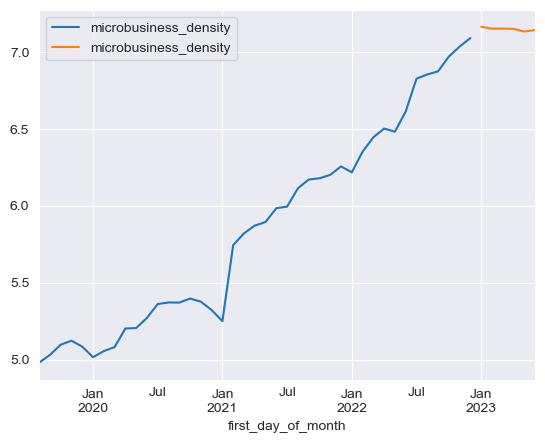

In [31]:
ax = raw.loc[(raw.cfips==10001)&(raw.istest==0)].plot(x='first_day_of_month', y='microbusiness_density');
raw.loc[(raw.cfips==10001)&(raw.istest==1)].plot(ax=ax, x='first_day_of_month', y='microbusiness_density');

<AxesSubplot:xlabel='first_day_of_month'>

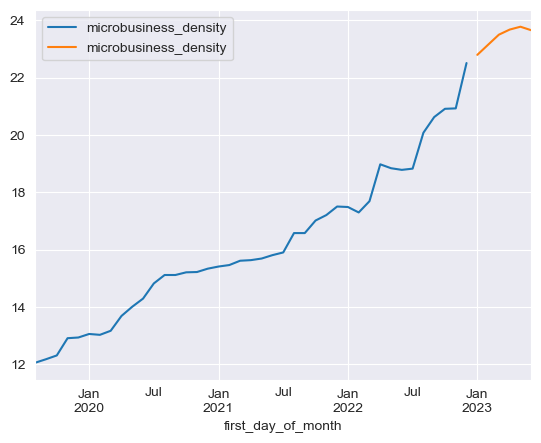

In [32]:
ax = raw.loc[(raw.cfips==10003)&(raw.istest==0)].plot(x='first_day_of_month', y='microbusiness_density')
raw.loc[(raw.cfips==10003)&(raw.istest==1)].plot(ax=ax, x='first_day_of_month', y='microbusiness_density')

<AxesSubplot:xlabel='first_day_of_month'>

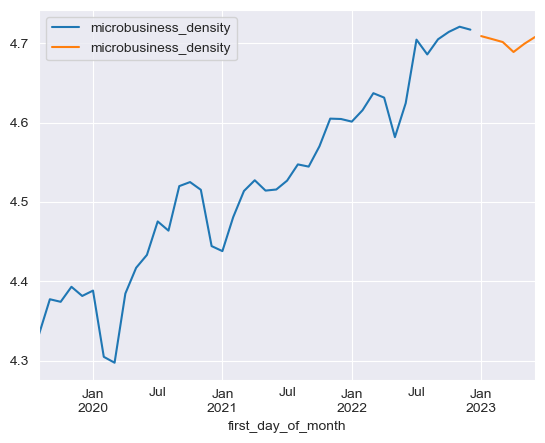

In [33]:
ax = raw.loc[(raw.cfips==9011)&(raw.istest==0)].plot(x='first_day_of_month', y='microbusiness_density')
raw.loc[(raw.cfips==9011)&(raw.istest==1)].plot(ax=ax, x='first_day_of_month', y='microbusiness_density')

<AxesSubplot:xlabel='first_day_of_month'>

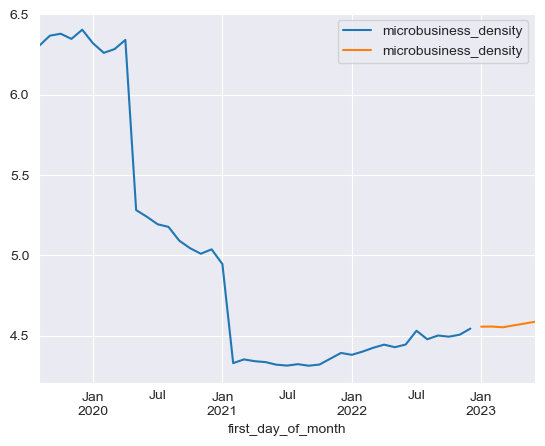

In [34]:
ax = raw.loc[(raw.cfips==9013)&(raw.istest==0)].plot(x='first_day_of_month', y='microbusiness_density')
raw.loc[(raw.cfips==9013)&(raw.istest==1)].plot(ax=ax, x='first_day_of_month', y='microbusiness_density')

<AxesSubplot:xlabel='first_day_of_month'>

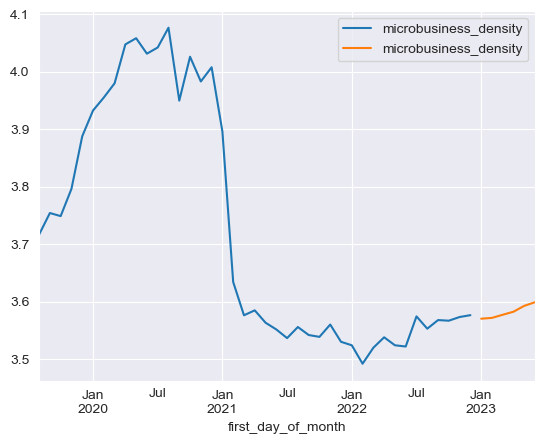

In [35]:
ax = raw.loc[(raw.cfips==9015)&(raw.istest==0)].plot(x='first_day_of_month', y='microbusiness_density')
raw.loc[(raw.cfips==9015)&(raw.istest==1)].plot(ax=ax, x='first_day_of_month', y='microbusiness_density')

In [36]:
test_upd = test_upd[['row_id', 'microbusiness_density']].copy()
test_upd

,row_id,microbusiness_density
0,1001_2022-11-01,3.442677
1,1001_2022-12-01,3.470915
2,1003_2022-11-01,8.257636
3,1003_2022-12-01,8.250630
4,1005_2022-11-01,1.247223
...,...,...
6265,56041_2022-12-01,4.050703
6266,56043_2022-11-01,3.143093
6267,56043_2022-12-01,3.060380
6268,56045_2022-11-01,1.785395


In [37]:
test = raw.loc[raw.istest==1, ['row_id', 'microbusiness_density']].copy()

In [38]:
test = pd.concat([test_upd, test])

In [39]:
test.to_csv('submission.csv', index=False)
test

,row_id,microbusiness_density
0,1001_2022-11-01,3.442677
1,1001_2022-12-01,3.470915
2,1003_2022-11-01,8.257636
3,1003_2022-12-01,8.250630
4,1005_2022-11-01,1.247223
...,...,...
144728,29186_2023-06-01,2.191746
145254,56035_2023-06-01,8.122742
145265,55101_2023-06-01,3.818370
147081,19005_2023-06-01,2.514281
